In [1]:
from __future__ import print_function
import pandas as pd;
import random
import numpy as np;
import matplotlib.pyplot as plt
import re
import pickle
import xgboost as xgb
pd.set_option('display.max_columns', 80) 
pd.set_option('display.max_rows', 100) 
%matplotlib inline
sample2submit = pd.read_csv('input/sample2submit.csv',sep = ',')

In [2]:
with open('Rdata.pickle', 'rb') as f:
    data = pickle.load(f)

In [3]:
%%time
#генерим фичи
data['NS1'] = (data['NUM_SOURCE'] == 1).astype(np.int8)
data['NS2'] = (data['NUM_SOURCE'] == 2).astype(np.int8)
data['NS3'] = (data['NUM_SOURCE'] == 3).astype(np.int8)
data['NS4'] = (data['NUM_SOURCE'] == 4).astype(np.int8)
del data['NUM_SOURCE']
data['CA0'] = (data['CREDIT_ACTIVE'] == 0).astype(np.int8)
data['CA1'] = (data['CREDIT_ACTIVE'] == 1).astype(np.int8)
data['CA2'] = (data['CREDIT_ACTIVE'] == 2).astype(np.int8)
data['CA3'] = (data['CREDIT_ACTIVE'] == 3).astype(np.int8)
del data['CREDIT_ACTIVE']
del data['CREDIT_COLLATERAL']
data['rub'] = (data['CREDIT_CURRENCY'] == 'rur').astype(np.int8)
data['usd'] = (data['CREDIT_CURRENCY'] == 'usd').astype(np.int8)
data['eur'] = (data['CREDIT_CURRENCY'] == 'eur').astype(np.int8)
del data['CREDIT_CURRENCY']
data['C_F'] = data['CREDIT_FACILITY'] 
del data['CREDIT_FACILITY']
tmp = data['CREDIT_DAY_OVERDUE'].value_counts(normalize=True).to_dict()
#добавить отношение CREDIT_DAY_OVERDUE к продолжительности кредита+
#добавить CREDIT_DAY_OVERDUE умножить на ежемесячный платеж+
tmp2 = data['CREDIT_DAY_OVERDUE'].isnull().sum() / float(len(data))
data['CDO_f'] = data['CREDIT_DAY_OVERDUE'].apply(lambda x:tmp2 if np.isnan(x) else tmp[x])
data['CDO'] = data['CREDIT_DAY_OVERDUE']
del data['CREDIT_DAY_OVERDUE']
data['ACMO/ACS'] = data['AMT_CREDIT_MAX_OVERDUE'] / data['AMT_CREDIT_SUM']
#добавить AMT_CREDIT_MAX_OVERDUE / на ежемесячный платеж+
data['ACMO'] = data['AMT_CREDIT_MAX_OVERDUE']
del data['AMT_CREDIT_MAX_OVERDUE']
data['CST'] = data['CREDIT_SUM_TYPE']
del data['CREDIT_SUM_TYPE']
data['CCP'] = data['CNT_CREDIT_PROLONG']
del data['CNT_CREDIT_PROLONG']
#добавить ежемесячный платеж+
data['ACS%'] = data['AMT_CREDIT_SUM'] % 1
data['ACS%1k'] = (data['AMT_CREDIT_SUM'].apply(lambda x: None if np.isnan(x) else int(x)) % 1000 == 0) * 1
data['ACS%5k'] = (data['AMT_CREDIT_SUM'].apply(lambda x: None if np.isnan(x) else int(x)) % 5000 == 0) * 1
data['ACS%10k'] = (data['AMT_CREDIT_SUM'].apply(lambda x: None if np.isnan(x) else int(x)) % 10000 == 0) * 1 
data['ACS%100k'] = (data['AMT_CREDIT_SUM'].apply(lambda x: None if np.isnan(x) else int(x)) % 100000 == 0) *1
tmp = data['AMT_CREDIT_SUM'].value_counts(normalize=True).to_dict()
data['ACS_f'] = data['AMT_CREDIT_SUM'].apply(lambda x:None if np.isnan(x) else tmp[x] )
data['ACS'] = data['AMT_CREDIT_SUM']
del data['AMT_CREDIT_SUM']

tmp = data['AMT_CREDIT_SUM_DEBT'].value_counts(normalize=True).to_dict()
data['ACSD_f'] = data['AMT_CREDIT_SUM_DEBT'].apply(lambda x:None if np.isnan(x) else tmp[x] )
data['ACSD'] = data['AMT_CREDIT_SUM_DEBT']
del data['AMT_CREDIT_SUM_DEBT']
data['ACSD/ACS'] = data['ACSD']/data['ACS']
data['ACSD/ACMO'] = data['ACSD']/ data['ACMO']
tmp = data['AMT_CREDIT_SUM_LIMIT'].value_counts(normalize=True).to_dict()
data['ACSL_f'] = data['AMT_CREDIT_SUM_LIMIT'].apply(lambda x:None if np.isnan(x) else tmp[x] )
data['ACSL'] = data['AMT_CREDIT_SUM_LIMIT']
del data['AMT_CREDIT_SUM_LIMIT']

tmp = data['AMT_CREDIT_SUM_OVERDUE'].value_counts(normalize=True).to_dict()
data['ACSO_f'] = data['AMT_CREDIT_SUM_OVERDUE'].apply(lambda x:None if np.isnan(x) else tmp[x] )
data['ACSO'] = data['AMT_CREDIT_SUM_OVERDUE']
del data['AMT_CREDIT_SUM_OVERDUE']
data['ACSO/ACS'] = data['ACSO'] / data['ACS']
data['ACSO/ACMO'] = data['ACSO'] / data['ACMO']
#ACSO / ежемесячный платеж +
data['CT5'] = (data['CREDIT_TYPE'] == 5) * 1
data['CT4'] = (data['CREDIT_TYPE'] == 4) * 1
data['CT19'] = (data['CREDIT_TYPE'] == 19) * 1
data['CT1'] = (data['CREDIT_TYPE'] == 1) * 1
data['CT3'] = (data['CREDIT_TYPE'] == 3) * 1
data['CT99'] = (data['CREDIT_TYPE'] == 99) * 1
data['CT6'] = (data['CREDIT_TYPE'] == 6) * 1
data['CT0'] = (data['CREDIT_TYPE'] == 0) * 1
data['CT7'] = (data['CREDIT_TYPE'] == 7) * 1
data['CT18'] = (data['CREDIT_TYPE'] == 18) * 1
data['CT9'] = (data['CREDIT_TYPE'] == 9) * 1
data['CT8'] = (data['CREDIT_TYPE'] == 8) * 1
data['CT10'] = (data['CREDIT_TYPE'] == 10) * 1
data['CT2'] = (data['CREDIT_TYPE'] == 2) * 1
del data['CREDIT_TYPE']

data['CD_SUM'] = data['CREDIT_DELAY30'] + data['CREDIT_DELAY5'] +  \
    data['CREDIT_DELAY60'] + data['CREDIT_DELAY90'] + data['CREDIT_DELAY_MORE']
data['CD_30/CD_SUM'] = data['CREDIT_DELAY30'] / data['CD_SUM']
#найти количество платежей+
#и эти все данные поделить на количество платяжей
data['CD30'] = data['CREDIT_DELAY30']
data['CD5'] = data['CREDIT_DELAY5']
data['CD60'] = data['CREDIT_DELAY60']
data['CD90'] = data['CREDIT_DELAY90']
data['CDMORE'] = data['CREDIT_DELAY_MORE']
del data['CREDIT_DELAY30']
del data['CREDIT_DELAY5']
del data['CREDIT_DELAY60']
del data['CREDIT_DELAY90']
del data['CREDIT_DELAY_MORE']

data['ARSSUM'] = data['AMT_REQ_SOURCE_HOUR'] + data['AMT_REQ_SOURCE_DAY'] + data['AMT_REQ_SOURCE_WEEK'] + \
     data['AMT_REQ_SOURCE_MON'] + data['AMT_REQ_SOURCE_QRT'] + data['AMT_REQ_SOURCE_YEAR']
data['ARSW'] = data['AMT_REQ_SOURCE_HOUR'] + data['AMT_REQ_SOURCE_DAY'] + data['AMT_REQ_SOURCE_WEEK']
data['ARSH'] = data['AMT_REQ_SOURCE_HOUR']
data['ARS1'] = data['AMT_REQ_SOURCE_DAY']
data['ARS7'] = data['AMT_REQ_SOURCE_WEEK']
data['ARS30'] = data['AMT_REQ_SOURCE_MON']
data['ARS90'] = data['AMT_REQ_SOURCE_QRT']
data['ARS365'] = data['AMT_REQ_SOURCE_YEAR']
# сумарное кол-во обращений к кол-ву кредитов
del data['AMT_REQ_SOURCE_HOUR']
del data['AMT_REQ_SOURCE_DAY']
del data['AMT_REQ_SOURCE_WEEK']
del data['AMT_REQ_SOURCE_MON']
del data['AMT_REQ_SOURCE_QRT']
del data['AMT_REQ_SOURCE_YEAR']
data['CDO*AA'] = data['CDO'] * data['AMT_ANNUITY']
data['ACMO*AA'] = data['ACMO'] / data['AMT_ANNUITY']
data['ACSO*AA']= data['ACSO'] / data['AMT_ANNUITY']
tmp = data['AMT_ANNUITY'].value_counts(normalize=True).to_dict()
data['AA_f'] = data['AMT_ANNUITY'].apply(lambda x:None if np.isnan(x) else tmp[x] )
data['AA'] = data['AMT_ANNUITY']
del data['AMT_ANNUITY']

data['S_c'] = data['TEXT_PAYMENT_DISCIPLINE'].str.count('C')
data['S_x'] = data['TEXT_PAYMENT_DISCIPLINE'].str.count('X')
data['S_0'] = data['TEXT_PAYMENT_DISCIPLINE'].str.count('0')
data['S_1'] = data['TEXT_PAYMENT_DISCIPLINE'].str.count('1')
data['S_2'] = data['TEXT_PAYMENT_DISCIPLINE'].str.count('2')
data['S_3'] = data['TEXT_PAYMENT_DISCIPLINE'].str.count('3')
data['S_4'] = data['TEXT_PAYMENT_DISCIPLINE'].str.count('4')
data['S_5'] = data['TEXT_PAYMENT_DISCIPLINE'].str.count('5')
data['S_prosr'] = data['S_1'] + data['S_2'] + data['S_3'] + data['S_4'] + data['S_5']
data['S_/'] = data['S_0'] / data['S_prosr']
data['count_payments'] = data['S_1'] + data['S_2'] + data['S_3'] + data['S_4'] + data['S_5'] + data['S_0']

TEXT_Freq = data['TEXT_PAYMENT_DISCIPLINE'].value_counts(normalize = True).to_dict()
TEXT_Freq_n = data['TEXT_PAYMENT_DISCIPLINE'].isnull().sum()/float(len(data['TEXT_PAYMENT_DISCIPLINE']))
data['TEXT_Freq'] = data['TEXT_PAYMENT_DISCIPLINE'].apply(lambda x:TEXT_Freq[x] if str(x) != 'nan'  else TEXT_Freq_n)
del data['TEXT_PAYMENT_DISCIPLINE']

data['AA2'] = data['ACS'] / data['count_payments']
data['CDO*AA2'] = data['CDO'] * data['AA2']
data['ACMO*AA2'] = data['ACMO'] / data['AA2']
data['ACSO*AA2']= data['ACSO'] / data['AA2']
data['CD_SUM/p'] = data['CD_SUM'] / data['count_payments']
data['CD30/p'] = data['CD30'] / data['count_payments']
data['CD5/p'] = data['CD5'] / data['count_payments']
data['CD60/p'] = data['CD60'] / data['count_payments']
data['CD90/p'] = data['CD90'] / data['count_payments']
data['CDMORE/p'] = data['CDMORE'] / data['count_payments']

data['credit_time'] = (data['DTIME_CREDIT_ENDDATE'] - data['DTIME_CREDIT']).apply(lambda x: x.days) / 30.4167
data['month'] = (data['credit_time']).round()
tmp = data['month'].value_counts(normalize=True).to_dict()
data['month_f'] = data['month'].apply(lambda x:None if np.isnan(x) else tmp[x] )
data['CDO/credit_time'] = data['CDO'] / (data['credit_time'] * 30.4167)
data['AA3'] = data['ACS'] / (data['credit_time'] )
data['CDO*AA3'] = data['CDO'] * data['AA3']
data['ACMO*AA3'] = data['ACMO'] / data['AA3']
data['ACSO*AA3'] = data['ACSO'] / data['AA3']

data['CD_SUM/p'] = data['CD_SUM'] / data['credit_time']
data['CD30/p'] = data['CD30'] / data['credit_time']
data['CD5/p'] = data['CD5'] / data['credit_time']
data['CD60/p'] = data['CD60'] / data['credit_time']
data['CD90/p'] = data['CD90'] / data['credit_time']
data['CDMORE/p'] = data['CDMORE'] / data['credit_time']

data['prosrochka']=(data['DTIME_CREDIT_ENDDATE_FACT']-data['DTIME_CREDIT_ENDDATE']).apply(lambda x: x.days) / 30.4167
data['AA3*prosrochka']  = data['AA3'] * data['prosrochka']
data['AA2*prosrochka']  = data['AA2'] * data['prosrochka']
data['AA*prosrochka']  = data['AA'] * data['prosrochka']
data['ACSD/prosrochka'] = data['ACSD'] / data['prosrochka']
data['ACMO/prosrochka'] = data['ACMO'] / data['prosrochka']
data['CDO/prosrochka'] = data['CDO'] / data['prosrochka']
data['ACSO/prosrochka'] = data['ACSO'] / data['prosrochka']
data['prosr2'] = data['prosrochka'] / data['credit_time']
data['time_long'] = (data['SK_DATE_DECISION'] - data['DTIME_CREDIT_ENDDATE_FACT']).apply(lambda x: x.days) / 30.4167
del data['DTIME_CREDIT_ENDDATE']
del data['DTIME_CREDIT_ENDDATE_FACT']
del data['SK_DATE_DECISION']
del data['DTIME_CREDIT']
del data['DTIME_CREDIT_UPDATE']

CPU times: user 57 s, sys: 676 ms, total: 57.7 s
Wall time: 57 s


In [4]:
#чтобы данные меньше весили, сожмем то, что можем сждать
for i in data.columns:
    if ((data[i].dtype == np.int64) or (data[i].dtype == np.int8)) and (data[i].max() == 1) and (data[i].min() == 0) and (len(data[i].value_counts()) == 2):
        data[i] = data[i].astype(np.bool_)
    elif (data[i].dtype == np.int64) and (data[i].max() < 127) and (data[i].min() > -126) and (len(data[i].value_counts()) < 120):
        data[i] = data[i].astype(np.int8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1752630 entries, 3233431 to 3066169
Columns: 111 entries, ID to time_long
dtypes: bool(30), float64(63), int64(4), int8(14)
memory usage: 1.0 GB


In [6]:
data.shape

(1752630, 111)

In [14]:
data.head()

,ID,y,NS1,NS2,NS3,NS4,CA0,CA1,CA2,CA3,rub,usd,eur,C_F,CDO_f,CDO,ACMO/ACS,ACMO,CST,CCP,ACS%,ACS%1k,ACS%5k,ACS%10k,ACS%100k,ACS_f,ACS,ACSD_f,ACSD,ACSD/ACS,ACSD/ACMO,ACSL_f,ACSL,ACSO_f,ACSO,ACSO/ACS,ACSO/ACMO,CT5,CT4,CT19,...,S_c,S_x,S_0,S_1,S_2,S_3,S_4,S_5,S_prosr,S_/,count_payments,TEXT_Freq,AA2,CDO*AA2,ACMO*AA2,ACSO*AA2,CD_SUM/p,CD30/p,CD5/p,CD60/p,CD90/p,CDMORE/p,credit_time,month,month_f,CDO/credit_time,AA3,CDO*AA3,ACMO*AA3,ACSO*AA3,prosrochka,AA3*prosrochka,AA2*prosrochka,AA*prosrochka,ACSD/prosrochka,ACMO/prosrochka,CDO/prosrochka,ACSO/prosrochka,prosr2,time_long
3233431,293262,-1,True,False,False,False,True,False,False,False,True,False,False,NaN,0.997491,0,NaN,NaN,True,0,0.0,True,True,True,True,0.039738,0.0,0.753589,0.0,NaN,NaN,0.927722,0.0,0.997446,0.0,NaN,NaN,False,True,False,...,52.0,58.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,9.0,0.000001,0.000000,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1121.028908,1121.0,0.000018,0.0,0.000000,0.0,NaN,NaN,-1054.223502,-0.000000,-0.000000,-0.0,-0.0,NaN,-0.0,-0.0,-0.940407,51.123232
1298420,133347,0,True,False,False,False,True,False,False,False,True,False,False,NaN,0.997491,0,NaN,NaN,True,0,0.0,True,False,False,False,0.003175,6000.0,0.753589,0.0,0.0,NaN,0.927722,0.0,0.997446,0.0,0.0,NaN,True,False,False,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.000875,inf,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.460273,0.0,0.006976,0.0,13035.728571,0.0,NaN,0.0,-0.032877,-428.571429,-inf,-0.0,-0.0,NaN,-0.0,-0.0,-0.071429,7.989032
305737,52008,0,False,False,False,True,True,False,False,False,True,False,False,NaN,0.997491,0,0.0,0.0,False,0,0.0,False,False,False,False,0.000066,19999.0,0.753589,0.0,0.0,NaN,0.927722,0.0,0.997446,0.0,0.0,NaN,True,False,False,...,30.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,8.0,0.000202,2499.875000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.956156,8.0,0.018399,0.0,2513.651171,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,28.405448
2419115,228528,-1,False,False,False,True,True,False,False,False,True,False,False,NaN,0.997491,0,0.0,0.0,False,0,0.0,False,False,False,False,0.000046,5950.0,0.753589,0.0,0.0,NaN,0.927722,0.0,0.997446,0.0,0.0,NaN,True,False,False,...,4.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,6.0,0.000426,991.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.049308,6.0,0.096282,0.0,983.583505,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,3.320544
1910467,184743,-1,False,False,False,True,True,False,False,False,True,False,False,NaN,0.997491,0,0.0,0.0,False,0,0.0,False,False,False,False,0.000015,41650.0,0.753589,0.0,0.0,NaN,0.927722,0.0,0.997446,0.0,0.0,NaN,True,False,False,...,26.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,inf,5.0,0.000284,8330.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.016432,6.0,0.096282,0.0,6922.707951,0.0,0.0,0.0,-1.019177,-7055.464481,-8489.744121,NaN,-0.0,-0.0,-0.0,-0.0,-0.169399,24.427370


In [9]:
%%time
idd = data['ID']
#возьмем всевозможные статистики по кредитам
df = data.groupby('ID').agg(['min', 'max','mean','sum','median'])

CPU times: user 16.8 s, sys: 244 ms, total: 17 s
Wall time: 17.1 s


In [10]:
df.shape

(255722, 550)

In [12]:
#разделили на трейн и тест, запомнили тестовые иднексы
idd_test = df.loc[df['y']['mean'] == -1].index
x_train = df[df['y']['mean'] > -1]
x_test = df[df['y']['mean'] == -1]
y = x_train['y']['mean']
del x_train['y']
del x_test['y']

In [13]:
dtrain = xgb.DMatrix(x_train.values, label=y)
dtest = xgb.DMatrix(x_test.values)

In [13]:
%%time
#c  помощью cv нашли оптимальное кол-во дереьвев
param = {'max_depth':4, 'eta':0.01, 'silent':0,
         'objective':'binary:logistic',
         'subsample':0.8,
         'colsample_bytree':0.8,
         'seed':202,
        }
trees = 10000
cv = xgb.cv(param, dtrain, metrics=('auc'), show_stdv=True,
            num_boost_round=trees,nfold=2,early_stopping_rounds = 50)

CPU times: user 51min 12s, sys: 2.74 s, total: 51min 14s
Wall time: 13min 48s


test-auc-mean     0.693723
test-auc-std      0.003450
train-auc-mean    0.846159
train-auc-std     0.000912
Name: 1233, dtype: float64


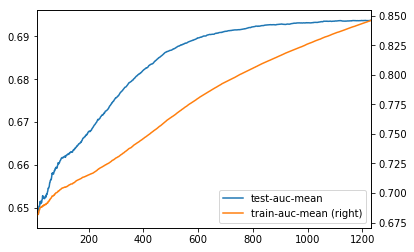

In [14]:
cv[10:].plot(y=['test-auc-mean', 'train-auc-mean'], secondary_y='train-auc-mean')
print (cv.loc[cv['test-auc-mean'].argmax()])
trees = cv['test-auc-mean'].argmax()

In [15]:
%%time
#обучили на всем трейне
bst = xgb.train(param,dtrain,trees)

CPU times: user 45min 23s, sys: 1.73 s, total: 45min 25s
Wall time: 12min 6s


In [16]:
#предсказали тест
ans = bst.predict(dtest)

In [17]:
#сформировали сабмит
a = pd.DataFrame()
a['ID'] = idd_test
a['Score'] = ans
b = a.groupby('ID').mean()
sample2submit['Score'] = np.array(b['Score'])
sample2submit.to_csv('ans.csv',index=False)

In [89]:
sample2submit

,ID,Score
0,174640,0.019009
1,174641,0.035556
2,174642,0.028653
3,174643,0.026133
4,174644,0.124069
5,174645,0.018565
6,174646,0.054022
7,174647,0.025577
8,174648,0.020242
9,174650,0.034049
